# VinBigData Chest X-ray Abnormalities Detection

## Yolov8 model: Data Preprocessing, Training and Inference

**Author: Théo LANGÉ** - s394369 - theo.lange.369@cranfield.ac.uk

This notebook describes the Yolov8 complete Pipeline for training a Yolov8x pre-trained model and making inference on the test set.

It requires as input the processed data obtained through the notebook `AI_VinBigData_Data_Preprocessing`. One could also access the resulting data directly on kaggle: 
> https://www.kaggle.com/datasets/theolange/ai-vinbigdata

For this notebook to work outside of kaggle, you will need to update the last cell in the `Setup` section to precise the path of all the needed directory. 

As of now, this pipeline will divide the train set into a train and validation set using the KFold method. One of the 5 fold created can be then used for validation. By default, the fold 4 will be used. You can change this by updating the parameter `VAL_FOLD` in the last cell of the `Setup` section.

## Table of contents
0. [Libraries and Setup](#0)
1. [Data Preprocessing](#1)
2. [Model Training and Validation](#2)
3. [Model Inference](#3)
4. [Submission File](#4)
5. [Working Directory Cleaning](#5)

<a id="0"></a>
# 0. Libraries and Setup

In [1]:
pip install -q ultralytics ensemble_boxes

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import shutil
from glob import glob
from os import listdir
from os.path import isfile, join
import yaml

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import GroupKFold

from ultralytics import YOLO
from ensemble_boxes import *
import torch

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define the root data directory
DATA_DIR = "/kaggle/input/ai-vinbigdata"

# Define the paths to the training and testing dicom folders respectively
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
LABELS_DIR = os.path.join(DATA_DIR, "labels")

# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test_meta.csv")

# Working directory
WORKING_DIR = "/kaggle/working"

VAL_FOLD = 4
IMGSZ = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a id="1"></a>
## 1. Data Preprocessing

Yolov8 models require specific input data. The dataset therefore need to be preprocessed.
In addition, Boxes fusion will be applied to each images to merge annotations

In [4]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head(10)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,img_original_height,img_original_width,x_min_resized,y_min_resized,x_max_resized,y_max_resized
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080,180.0,301.0,390.0,401.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2880,2304,276.0,132.0,338.0,181.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,3072,2540,NaN,NaN,NaN,NaN
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,3072,2540,149.0,60.0,202.0,72.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2555,2285,297.0,49.0,466.0,435.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,3353,2568,145.0,359.0,163.0,379.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0,2880,2304,287.0,132.0,322.0,170.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0,3072,2540,354.0,268.0,399.0,339.0


In [5]:
"""
This function will select only the 14 abnormal classes for training
Then, it will determine the absolute position of the center of the bounding boxes as well as their 
absolute shape given the shape of the images (512, 512)

Input: Train DataFrame
Output: Updated Train DataFrame with bounding boxes stores as xywh
"""

def process_data(train_df):
    # For 14 class training only
    train_df = train_df[train_df.class_id!=14].reset_index(drop = True)
    
    # Add the path to the image
    train_df['image_path'] = TRAIN_DIR + '/' + train_df.image_id+'.jpeg'

    # Pre-processing the dataset by computing the values of x_min,x_max,x_mid,y_min,y_max,y_mid,height and width
    # The position of the bounding boxes on the resized images is considered
    train_df['x_min'] = train_df.apply(lambda row: (row.x_min_resized)/512, axis =1)
    train_df['x_max'] = train_df.apply(lambda row: (row.x_max_resized)/512, axis =1)

    train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)

    train_df['y_min'] = train_df.apply(lambda row: (row.y_min_resized)/512, axis =1)
    train_df['y_max'] = train_df.apply(lambda row: (row.y_max_resized)/512, axis =1)
    
    train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

    train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1) #height
    train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1) #width
    
    return train_df

In [6]:
# Apply the processing to the Train DataFrame
train_df = process_data(train_df)
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,img_original_height,img_original_width,x_min_resized,y_min_resized,x_max_resized,y_max_resized,image_path,x_mid,y_mid,h,w
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.351562,0.587891,0.761719,0.783203,2336,2080,180.0,301.0,390.0,401.0,/kaggle/input/ai-vinbigdata/train/9a5094b2563a...,0.556641,0.685547,0.195312,0.410156
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.539062,0.257812,0.660156,0.353516,2880,2304,276.0,132.0,338.0,181.0,/kaggle/input/ai-vinbigdata/train/051132a778e6...,0.599609,0.305664,0.095703,0.121094
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.291016,0.117188,0.394531,0.140625,3072,2540,149.0,60.0,202.0,72.0,/kaggle/input/ai-vinbigdata/train/1c32170b4af4...,0.342773,0.128906,0.023438,0.103516
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.580078,0.095703,0.910156,0.849609,2555,2285,297.0,49.0,466.0,435.0,/kaggle/input/ai-vinbigdata/train/0c7a38f293d5...,0.745117,0.472656,0.753906,0.330078
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.283203,0.701172,0.318359,0.740234,3353,2568,145.0,359.0,163.0,379.0,/kaggle/input/ai-vinbigdata/train/47ed17dcb2cb...,0.300781,0.720703,0.039062,0.035156


In [7]:
"""
Retrieve the list of all the classes

Input: Train DataFrame
Output: A list of abnormalities class
"""

def get_class_list(train_df):
    
    # To get a list of the class names
    class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
    class_list = list(np.array(class_names)[np.argsort(class_ids)])
    class_list = list(map(lambda x: str(x), class_list))
    display(class_list)
    return class_list

# Get the list of abnormalities in the Train DataFrame
class_list = get_class_list(train_df)

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [8]:
"""
This function will use the method WBF from the package ensemble_boxes to fuse the boxes depending on
their location and labels
It then write new labels text files to be used during training

Input: Train DataFrame
Output: None, create new labels .txt files for the storage of the fused bounding boxes
"""

def boxes_fusion(train_df):
    
    # Create a directory to store the files
    os.makedirs(os.path.join(WORKING_DIR,'labels'), exist_ok = True)

    # Retrieve all the bounding boxes of every images
    for img_id in tqdm(sorted(train_df.image_id.unique())):
        labels = []
        boxes = []
        scores = []

        for row in train_df[train_df.image_id==img_id].values:
            labels.append(row[2])
            scores.append(1.0)
            boxe = [row[i] for i in range (4,8)]
            boxes.append(boxe)

        # Merge boxes
        boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], weights=None, iou_thr=0.4, skip_box_thr=0.0001)

        # Write a .txt label file with the new fused bounding boxes
        with open(f'/kaggle/working/labels/{img_id}.txt', 'w+') as f:
            for i in range (len(labels)):
                x_mid = str((boxes[i][0] + boxes[i][2])/2)
                y_mid = str((boxes[i][1] + boxes[i][3])/2)

                w = str(boxes[i][2] - boxes[i][0])
                h = str(boxes[i][3] - boxes[i][1])

                text = str(int(labels[i])) + ' ' + str(x_mid) + ' ' + str(y_mid) + ' ' + str(w) + ' ' + str(h)
                f.write(text)
                f.write('\n')

In [9]:
# Fuse the bounding boxes and write .txt files
boxes_fusion(train_df)
LABELS_DIR = os.path.join(WORKING_DIR,'labels')

  0%|          | 0/4394 [00:00<?, ?it/s]

### Split the dataset

In [10]:
# The training set is then split into 5 different folds
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1

# The annotations of an image will be added to the same fold
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
    
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,img_original_height,img_original_width,x_min_resized,y_min_resized,x_max_resized,y_max_resized,image_path,x_mid,y_mid,h,w,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.351562,0.587891,0.761719,0.783203,2336,2080,180.0,301.0,390.0,401.0,/kaggle/input/ai-vinbigdata/train/9a5094b2563a...,0.556641,0.685547,0.195312,0.410156,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.539062,0.257812,0.660156,0.353516,2880,2304,276.0,132.0,338.0,181.0,/kaggle/input/ai-vinbigdata/train/051132a778e6...,0.599609,0.305664,0.095703,0.121094,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.291016,0.117188,0.394531,0.140625,3072,2540,149.0,60.0,202.0,72.0,/kaggle/input/ai-vinbigdata/train/1c32170b4af4...,0.342773,0.128906,0.023438,0.103516,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.580078,0.095703,0.910156,0.849609,2555,2285,297.0,49.0,466.0,435.0,/kaggle/input/ai-vinbigdata/train/0c7a38f293d5...,0.745117,0.472656,0.753906,0.330078,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.283203,0.701172,0.318359,0.740234,3353,2568,145.0,359.0,163.0,379.0,/kaggle/input/ai-vinbigdata/train/47ed17dcb2cb...,0.300781,0.720703,0.039062,0.035156,4


In [11]:
"""
The initial train set is split into a training and a validating set (80/20)
Each images and labels files are copied to the right directory for the yolo model to train

Input: Train DataFrame, validating fold
Output: None, files will be copied to the right directory
"""

def split_data(train_df, fold):
    
    # Retrieve training and validating files location
    val_files   = []
    train_files = []
    val_files += list(train_df[train_df.fold==fold].image_path.unique())
    train_files += list(train_df[train_df.fold!=fold].image_path.unique())
    
    # Create all the needed directory
    os.makedirs(os.path.join(WORKING_DIR, "vinbigdata/labels/train"), exist_ok = True)
    os.makedirs(os.path.join(WORKING_DIR, "vinbigdata/labels/val"), exist_ok = True)
    os.makedirs(os.path.join(WORKING_DIR, "vinbigdata/images/train"), exist_ok = True)
    os.makedirs(os.path.join(WORKING_DIR, "vinbigdata/images/val"), exist_ok = True)
    label_dir = LABELS_DIR
    
    # Copy all the files
    for file in tqdm(train_files): # we use tqdm to see the progress of the copying of files
        shutil.copy(file, os.path.join(WORKING_DIR, "vinbigdata/images/train"))
        filename = file.split('/')[-1].split('.')[0]
        shutil.copy(os.path.join(label_dir, filename+'.txt'), os.path.join(WORKING_DIR, "vinbigdata/labels/train"))

    for file in tqdm(val_files):
        shutil.copy(file, os.path.join(WORKING_DIR, "vinbigdata/images/val"))
        filename = file.split('/')[-1].split('.')[0]
        shutil.copy(os.path.join(label_dir, filename+'.txt'), os.path.join(WORKING_DIR, "vinbigdata/labels/val"))

In [12]:
# Split the data and copy files according to the validating fold set up at the beginning of the notebook
split_data(train_df, VAL_FOLD)

  0%|          | 0/3515 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

In [13]:
"""
This function writes the .yaml file needed for the training of any Yolo model
It precises the name of each classes in order, the number of classes
and the directory of the training and validating sets

Input: None
Output: None, write a .yaml file for training and validating
"""

def write_yaml_data():
    
    #  Creating a yaml file 
    cwd = WORKING_DIR

    # Create a .txt file with the location of all the train set
    with open(join( cwd , 'train.txt'), 'w') as f:
        for path in glob(os.path.join(WORKING_DIR, "vinbigdata/images/train/*")):
            f.write(path+'\n')

    # Create a .txt file with the location of all the validation set
    with open(join( cwd , 'val.txt'), 'w') as f:
        for path in glob(os.path.join(WORKING_DIR, "vinbigdata/images/val/*")):
            f.write(path+'\n')

    # dict with the location of the needed file for training and validating, the number of classes and the classes
    data = dict(
        train =  join( cwd , 'train.txt') ,
        val   =  join( cwd , 'val.txt' ),
        nc    = 14,
        names = class_list
        )

    # Create a yaml file for the model training and validation
    with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False)

    f = open(join( cwd , 'vinbigdata.yaml'), 'r')
    print('\nyaml contents:')
    print(f.read())

In [14]:
# Writing the yaml file
write_yaml_data()


yaml contents:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /kaggle/working/train.txt
val: /kaggle/working/val.txt



<a id="2"></a>
## 2. Model Training and Validation

In this section, a Yolov8x pretrained model will be trained on the train set obtained after spliting. The trained model will be then validating using the validating set.

In [15]:
# We import a pretrained Yolov8x model
# The model will at the same time be trained and validated on the training and validating sets created before

model = YOLO("yolov8x.pt")
model.train(data=os.path.join(WORKING_DIR, "vinbigdata.yaml"), epochs=40, batch=16, imgsz=IMGSZ, conf=0.001)

  0%|          | 0.00/131M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.57 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/vinbigdata.yaml, epochs=40, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, 

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=14

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.Conv                  [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.Conv                  [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.C2f                   [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.Conv                  [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.C2f                   [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.Conv                  [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.C2f                   [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytic

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias
train: Scanning /kaggle/working/vinbigdata/labels/train... 3515 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3515/3515 [00:01<00:00, 2112.51it/s]
train: New cache created: /kaggle/working/vinbigdata/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/vinbigdata/labels/val... 879 images, 0 backgrounds, 0 corrupt: 100%|██████████| 879/879 [00:00<00:00, 2146.44it/s]
val: New cache created: /kaggle/working/vinbigdata/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/40     

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
"""
This function will plot validation figures such as loss and accuracy graphs

Input: None
Output: None, a figure is plotted
"""

def plot_validation_figure():
    plt.figure(figsize=(15,30))
    
    plt.axis('off')
    plt.imshow(plt.imread(os.path.join(WORKING_DIR, "runs/detect/train/results.png")));
    
    plt.show();

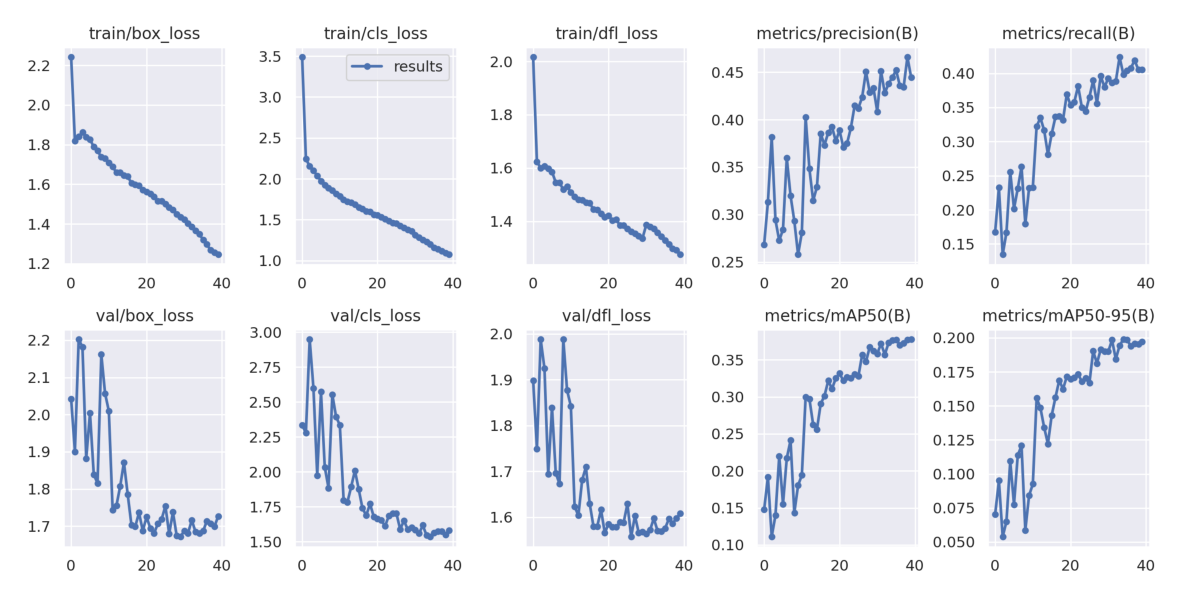

In [18]:
# Plot the validatino curves
plot_validation_figure()

In [19]:
"""
This function will plot the confusion matrix

Input: None
Output: None, a figure is plotted
"""

def plot_confusion_matrix():
    plt.figure(figsize=(30,30))
    
    plt.axis('off')
    plt.imshow(plt.imread(os.path.join(WORKING_DIR, "runs/detect/train/confusion_matrix.png")));
    
    plt.show();

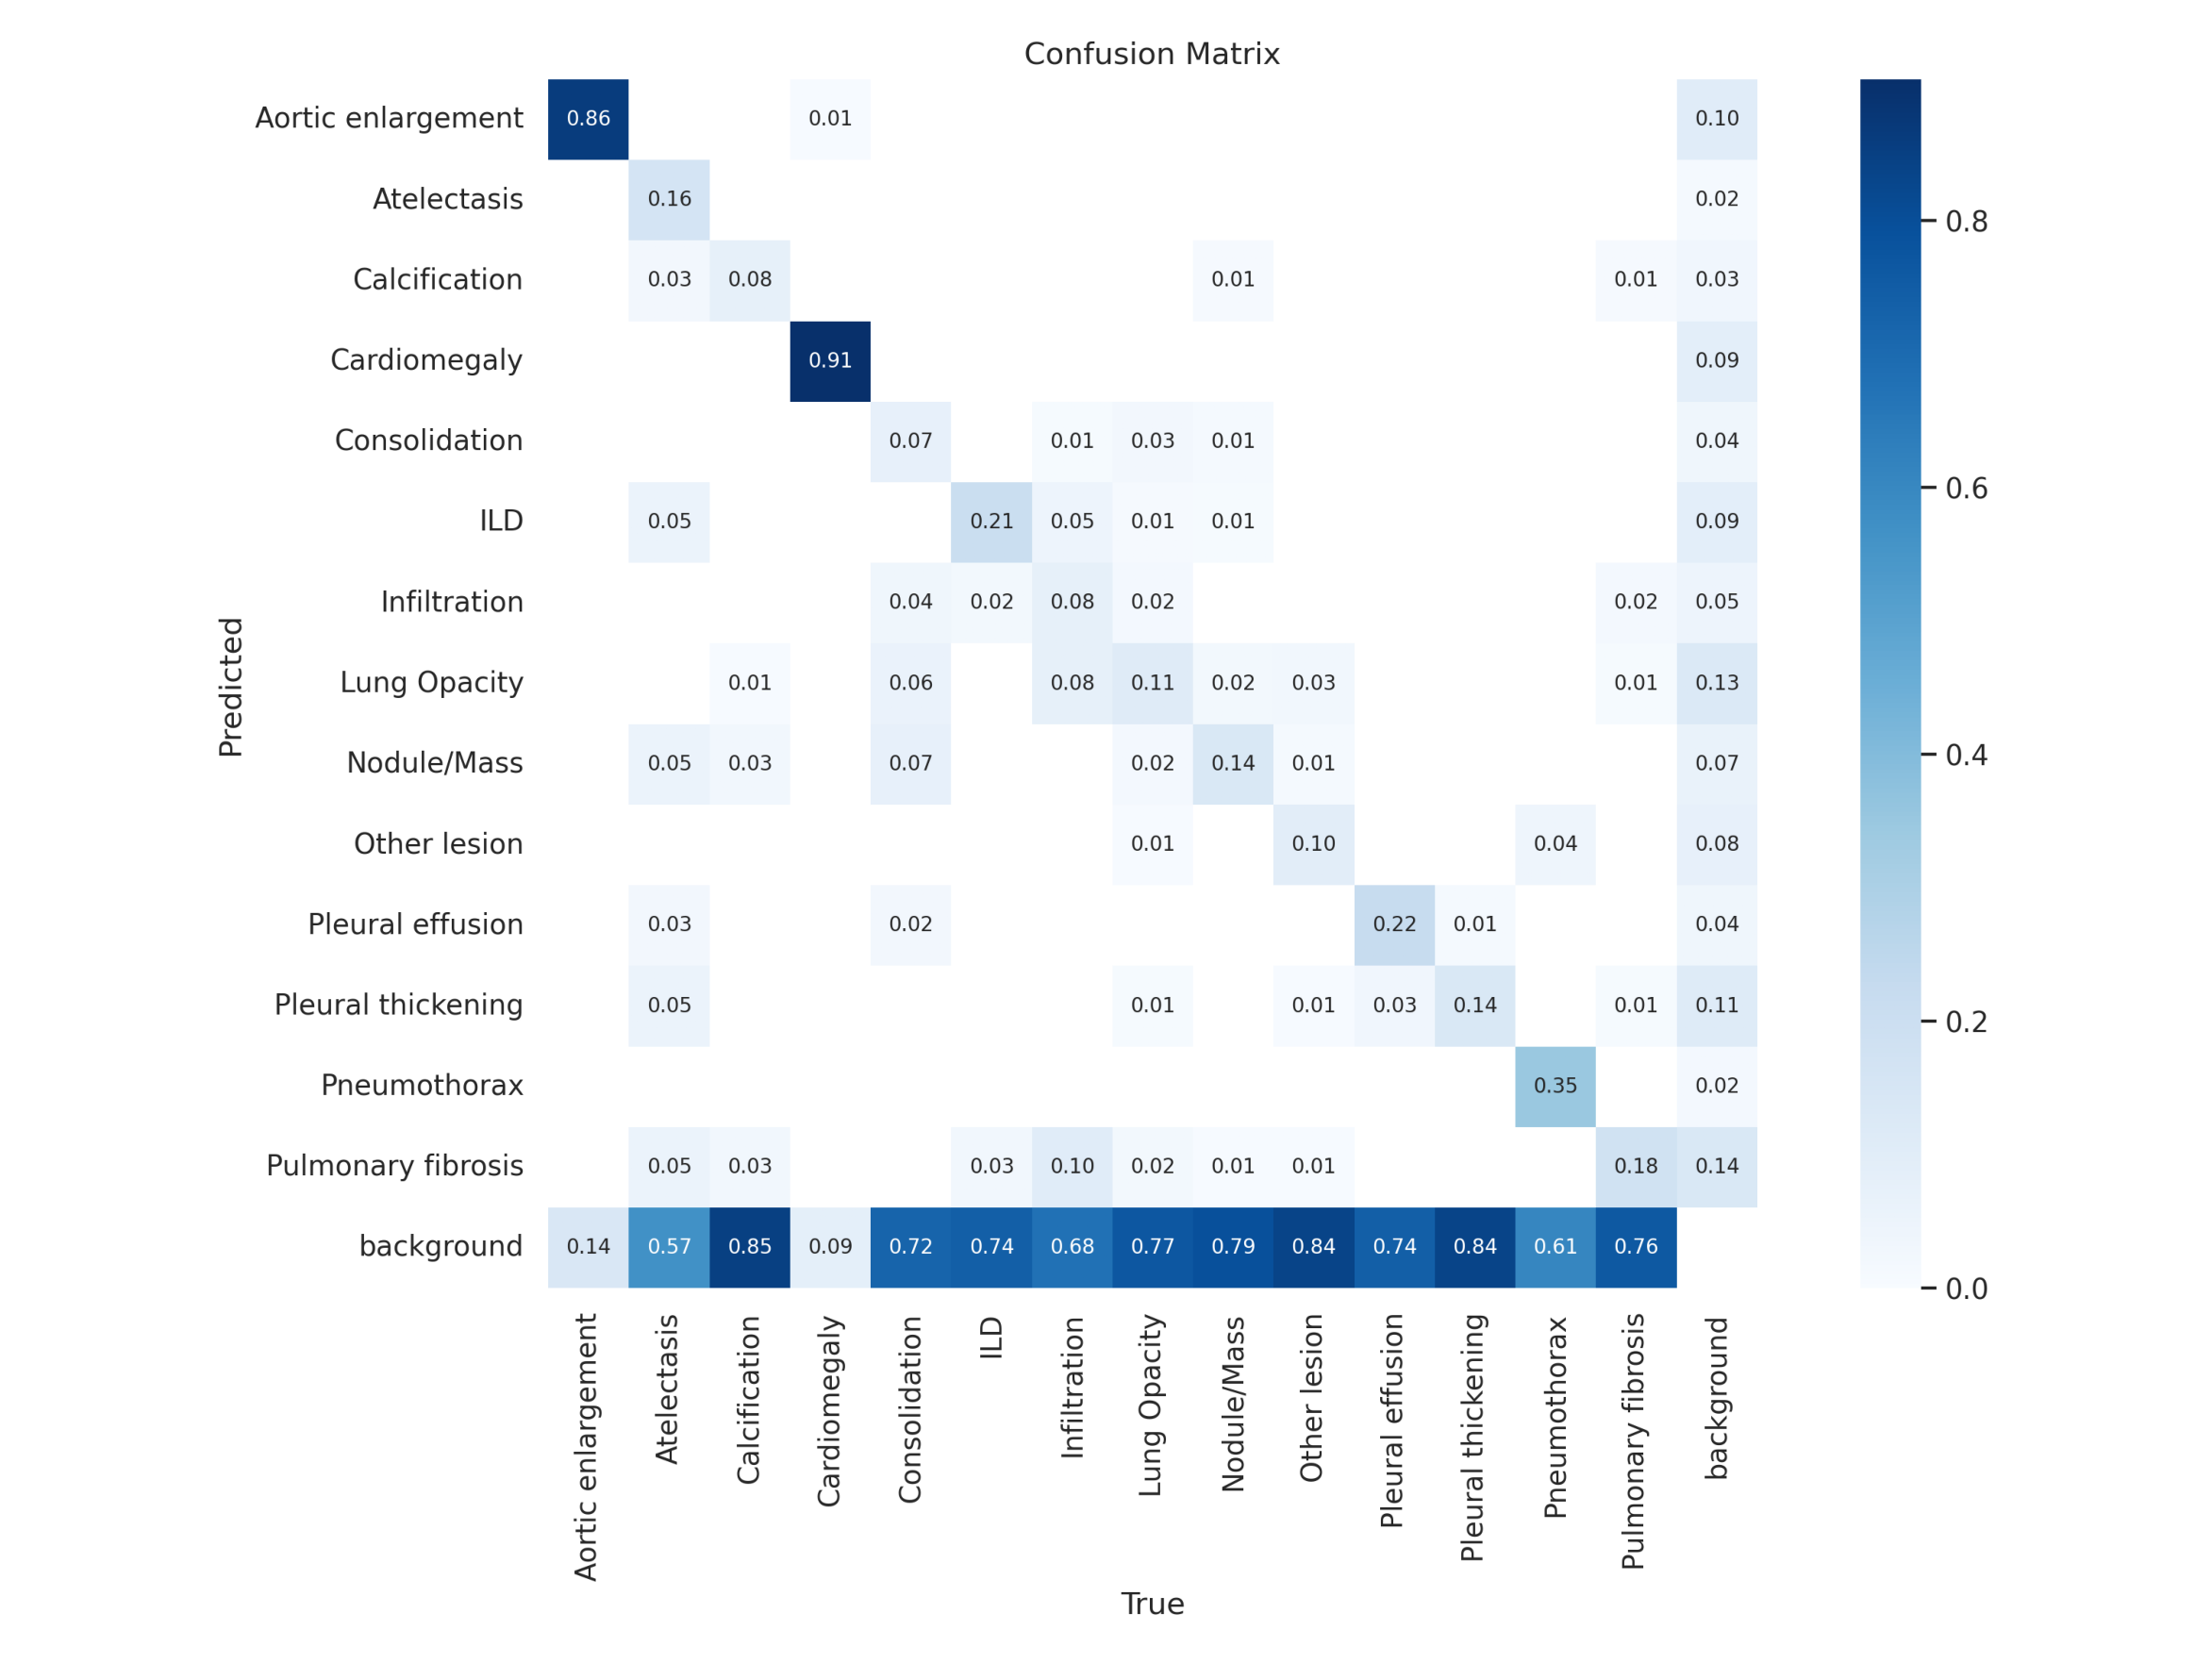

In [20]:
# Plot the confusion matrix
plot_confusion_matrix()

<a id="3"></a>
## 3. Model Inference

The trained model will be used to infer annotations on the test set

In [21]:
# We use the trained model to detect any abnormalities on the test set
results = model.predict(source=TEST_DIR, save=True, save_txt=True)


image 1/3000 /kaggle/input/ai-vinbigdata/test/002a34c58c5b758217ed1f584ccbcfe9.jpeg: 512x512 (no detections), 43.3ms
image 2/3000 /kaggle/input/ai-vinbigdata/test/004f33259ee4aef671c2b95d54e4be68.jpeg: 512x512 1 Aortic enlargement, 42.9ms
image 3/3000 /kaggle/input/ai-vinbigdata/test/008bdde2af2462e86fd373a445d0f4cd.jpeg: 512x512 1 Aortic enlargement, 1 Cardiomegaly, 43.7ms
image 4/3000 /kaggle/input/ai-vinbigdata/test/009bc039326338823ca3aa84381f17f1.jpeg: 512x512 1 Aortic enlargement, 1 Cardiomegaly, 42.9ms
image 5/3000 /kaggle/input/ai-vinbigdata/test/00a2145de1886cb9eb88869c85d74080.jpeg: 512x512 1 Aortic enlargement, 1 Cardiomegaly, 42.9ms
image 6/3000 /kaggle/input/ai-vinbigdata/test/00b7e6bfa4dc1fe9ddd0ce74743e38c2.jpeg: 512x512 2 Aortic enlargements, 1 Cardiomegaly, 42.9ms
image 7/3000 /kaggle/input/ai-vinbigdata/test/011295e0bcdc7636569ab73bfdcc4450.jpeg: 512x512 1 Pleural thickening, 42.8ms
image 8/3000 /kaggle/input/ai-vinbigdata/test/013c169f9dad6f1f6485da961b9f7bf2.jpeg: 

<a id="4"></a>
## 4. Submission File

Given the model predictions and the test images original sizes, a submission file of the right format is created. Each boxes are replaced according to the shape of the original images.

In [22]:
test_meta = pd.read_csv(TEST_CSV)
test_meta.head(10)

,image_id,img_height,img_width
0,002a34c58c5b758217ed1f584ccbcfe9,2584,2345
1,004f33259ee4aef671c2b95d54e4be68,3028,2517
2,008bdde2af2462e86fd373a445d0f4cd,2880,2304
3,009bc039326338823ca3aa84381f17f1,2430,1994
4,00a2145de1886cb9eb88869c85d74080,2408,2136
5,00b7e6bfa4dc1fe9ddd0ce74743e38c2,3000,3000
6,011295e0bcdc7636569ab73bfdcc4450,2430,1994
7,013c169f9dad6f1f6485da961b9f7bf2,2836,2336
8,01431a2618c0ace741e4e270a37e20b9,2880,2304
9,0168eb925aa6f28a78b16134792f5d0e,2836,2336


In [23]:
"""
This function convert the labels, boxes and scores arrays into a string of the right format for submission

Input: a list of labels, boxes and scores
Output: A Prediction String in the right format
"""

def format_prediction_string(labels, boxes, scores):
    
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            int(j[0]), j[1], int(j[2][0]), int(j[2][1]), int(j[2][2]), int(j[2][3])))

    return " ".join(pred_strings)

In [24]:
"""
This function will convert the result of the detection stage into the submission file
A detection threshold of 0.2 is applied in order to validate a detection

Input: A list of detected abnormalities, Test DataFrame, device and a Detection Threshold
Output: A Prediction DataFrame in the right format for submission
"""

def prediction(results, test_meta, device, detection_threshold=0.2):
    
    preds = []

    temp = test_meta.values

    for result in results:
        # Get the image ID and its shape
        img_id = result.path.split('/')[-1][:-5]
        index = np.where(temp[:,0] == img_id)[0][0]
        h, w = temp[index,1], temp[index,2]
        
        # Default value for the prediction
        pred = {
                  'image_id': img_id,
                  'PredictionString': '14 1.0 0 0 1 1'
        }
        
        # This case means that the model has found an abnormality or more on the image
        if len(result.boxes.cls) != 0:
            # Retrieve the labels, bounding boxes and scores of any detection on the image
            if device == 'cuda:0':
                label = result.boxes.cls.cuda()
                label = label.cpu()
                label = label.to("cpu")          

                confs = result.boxes.conf.cuda()
                confs = confs.cpu()
                confs = confs.to("cpu")
                
                bboxes = result.boxes.xyxy.cuda()
                bboxes = bboxes.cpu()
                bboxes = bboxes.to("cpu")
                
            else:
                label = result.boxes.cls

                confs = result.boxes.conf

                bboxes = result.boxes.xyxy
                
            label = label.numpy()
            label = label.astype("int32")  
            
            confs = confs.numpy()
            
            bboxes = bboxes.numpy()
            bboxes = bboxes.astype("int32")
            
            # Apply the detection threshold
            selected = confs >= detection_threshold

            boxes = bboxes[selected]
            scores = confs[selected]
            labels = label[selected]
          
            # Reshape the boxes position to the size of the original images
            # As padding has been added to every images, we first need to translate the box according to the
            # amount of padding added before applying the shape ratio
            for i in range (len(boxes)):
                if h > w:
                    ratio = h/512
                    boxes[i][1] *= ratio
                    boxes[i][3] *= ratio

                    boxes[i][0] = (boxes[i][0] - (512-w/ratio)/2)*ratio
                    boxes[i][2] = (boxes[i][2] - (512-w/ratio)/2)*ratio
                  
                elif h < w:
                    ratio = w/512
                    boxes[i][0] *= ratio
                    boxes[i][2] *= ratio

                    boxes[i][1] = (boxes[i][1] - (512-h/ratio)/2)*ratio
                    boxes[i][3] = (boxes[i][3] - (512-h/ratio)/2)*ratio
                  
                  
                else:
                    for j in range (len(boxes[i])):
                        boxes[i][j] *= h/512
            
            # Change the prediction string in case something has been detected after the threshold
            if len(labels) != 0:
                pred = {
                              'image_id': img_id,
                              'PredictionString': format_prediction_string(labels, boxes, scores)
                }

        preds.append(pred)
    
    # Create the submission DataFrame
    pred_df = pd.DataFrame(preds, columns=['image_id', 'PredictionString'])
    return pred_df

In [25]:
# Get the submission file
pred_df = prediction(results, test_meta, device)
pred_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1.0 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,0 0.3108 1098 555 1566 993
2,008bdde2af2462e86fd373a445d0f4cd,3 0.8561 1090 1411 1933 1783 0 0.8505 1427 821...
3,009bc039326338823ca3aa84381f17f1,3 0.8441 664 1048 1552 1347 0 0.6869 1001 479 ...
4,00a2145de1886cb9eb88869c85d74080,3 0.8734 771 1274 1853 1631 0 0.8079 1119 710 ...


In [26]:
pred_df.to_csv(f"submission_Yolov8x_F{VAL_FOLD}.csv", index=None)

<a id="5"></a>
## 5. Working Directory Cleaning

Clean the working directory and save the useful files

In [27]:
shutil.rmtree(LABELS_DIR)
shutil.rmtree(os.path.join(WORKING_DIR, 'vinbigdata'))
rm_file = ['yolov8x.pt', 'yolov8n.pt', 'train.txt', 'val.txt', 'vinbigdata.yaml']
for file in rm_file:
    try:
        os.remove(os.path.join(WORKING_DIR, file))
    except:
        pass

copy_file = [os.path.join(WORKING_DIR, 'runs/detect/train/weights/best.pt'), os.path.join(WORKING_DIR, 'runs/detect/train/results.png'), os.path.join(WORKING_DIR, 'runs/detect/train/confusion_matrix.png')]
for file in copy_file:
    if file.split('/')[-1].split('.')[-1] == 'pt':
        shutil.copy(file, os.path.join(WORKING_DIR, f"best_Yolov8x_F{VAL_FOLD}.pt"))
    else:
        shutil.copy(file, WORKING_DIR)

shutil.rmtree(os.path.join(WORKING_DIR, 'runs'))